<a href="https://colab.research.google.com/github/m-t-abbasi/SpatialPlanning/blob/main/section6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

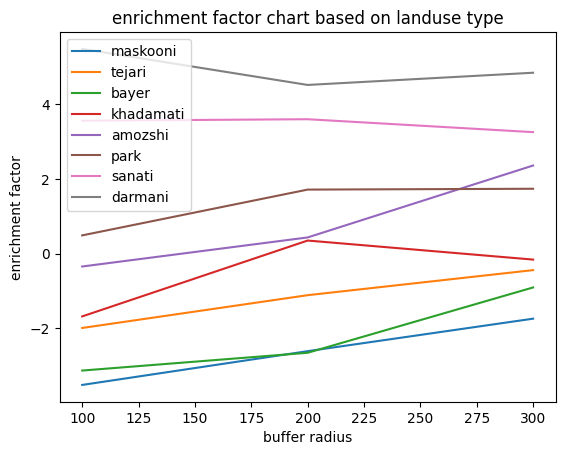

In [12]:
import geopandas as gpd
import numpy as np
import random
import matplotlib.pyplot as plt

# مسیر فایل شیپ را تعیین می کنیم
shapefile_path = "/content/landuse_shp.shp"

# خواندن فایل شیپ
gdf = gpd.read_file(shapefile_path)

# تعداد کل پارسل‌های منطقه
total_parcels = len(gdf)

# شمارش تعداد پارسل‌ها به تفکیک کاربری
landuse_counts = gdf['landuse2'].value_counts().to_dict()

# محاسبه مساحت هر کاربری بر حسب کل مساحت پارسل‌های منطقه
landuse_areas = gdf.groupby('landuse2')['SHAPE_Area'].sum().to_dict()

# تعریف اندازه‌های مختلف بافر
buffer_sizes = [100, 200, 300]

# دیکشنری برای ذخیره میانگین نسبت‌ها بر اساس کاربری و بافر
mean_ratios = {}

# تعداد پارسل‌هایی که برای محاسبه استفاده می‌شود
sample_size = 10

# پیمایش تک تک کاربری‌ها
for landuse_type in landuse_counts.keys():
    mean_ratios[landuse_type] = {}  # دیکشنری برای ذخیره میانگین نسبت‌ها بر اساس بافر
    
    # پیمایش تک تک اندازه‌های بافر
    for buffer_size in buffer_sizes:
        ratios = []  # لیستی برای ذخیره نسبت‌های محاسبه شده
        
        # انتخاب تصادفی ۱۰ پارسل برای محاسبه
        random_parcel_indices = random.sample(range(total_parcels), sample_size)
        
        # پیمایش تک تک پارسل‌های انتخاب شده
        for index in random_parcel_indices:
            row = gdf.iloc[index]
            parcel_id = row['OBJECTID']  # شماره پارسل
            
            buffer = row.geometry.buffer(buffer_size)
            
            # پیدا کردن پارسل‌هایی که کاملاً در داخل هر بافر قرار دارند
            parcels_within_buffer = gdf[gdf.geometry.within(buffer)]
            
            # شمارش تعداد پارسل‌ها به تفکیک کاربری
            landuse_counts_within_buffer = parcels_within_buffer['landuse2'].value_counts().to_dict()
            
            # محاسبه مساحت هر کاربری در هر بافر
            landuse_areas_within_buffer = parcels_within_buffer.groupby('landuse2')['SHAPE_Area'].sum().to_dict()
            
            # محاسبه نسبت آماری برای هر کاربری
            S_di = sum(landuse_areas_within_buffer.values())
            N_k = landuse_counts[landuse_type]
            S_k = landuse_areas[landuse_type]
            N = len(gdf)
            S = sum(landuse_areas.values())
            
            ratio = ((landuse_counts_within_buffer.get(landuse_type, 0) * landuse_areas_within_buffer.get(landuse_type, 0)) / (N_k * S_di)) / ((N_k * S_k) / (N * S))
            ratios.append(ratio)
    
        # محاسبه میانگین نسبت‌ها برای هر کاربری و بافر
        mean_ratio = np.mean(ratios)
        
        # ذخیره میانگین نسبت در دیکشنری
        mean_ratios[landuse_type][buffer_size] = mean_ratio

# ترسیم نمودارهای شاخص غنی شدگی بر اساس کاربری و بافر
for landuse_type in mean_ratios.keys():
    ratios = []  # لیستی برای ذخیره نسبت‌های محاسبه شده
    buffer_sizes = []  # لیستی برای ذخیره اندازه‌های بافر
    
    for buffer_size, mean_ratio in mean_ratios[landuse_type].items():
        buffer_sizes.append(buffer_size)
        ratios.append(np.log(mean_ratio))
    
    plt.plot(buffer_sizes, ratios, label=landuse_type)

# تنظیمات نمودار
plt.xlabel('buffer radius')
plt.ylabel('enrichment factor')
plt.title('enrichment factor chart based on landuse type')
plt.legend()
plt.show()


